In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [1]:
!pip install ale-py
!pip install gym[accept-rom-license,atari]
!pip install progressbar


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 9.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.6.1-py3-none-any.whl size=446660 sha256=8f189ded99f1481f473a83022fb5792fab557448c588299e68d1116a3ccc6996
  Stored in directory: /root/.cache/pip/wheels/6b/1b/ef/a43ff1a2f1736d5711faa1ba4c1f61be1131b8899e6a057811
Successfully built AutoROM.accept-rom-license
  Attempting uninstall: ale-py
    Found existing installation: ale-py 0.8.1
    Uninstalling ale-py-0.8.1:
      Successfully uninstalled ale-py-0.8.1
  Preparing metadata (setup.py) ... done
  Created wheel for progressbar: filename=progressbar-2.5-py3-none-any.whl size=12067 sha

***NOTE:***

This part implements a parallelEnv for reinforcement learning to increase the training speed.The training is performed by 4 parallel agents by default,but actually I use 8.

In [2]:

import numpy as np
import gym
from multiprocessing import Process, Pipe
from abc import ABC, abstractmethod

class CloudpickleWrapper(object):
    """
    Uses cloudpickle to serialize contents (otherwise multiprocessing tries to use pickle)
    """

    def __init__(self, x):
        self.x = x

    def __getstate__(self):
        import cloudpickle
        return cloudpickle.dumps(self.x)

    def __setstate__(self, ob):
        import pickle
        self.x = pickle.loads(ob)

class VecEnv(ABC):
    """
    An abstract asynchronous, vectorized environment.
    """

    def __init__(self, num_envs, observation_space, action_space):
        self.num_envs = num_envs
        self.observation_space = observation_space
        self.action_space = action_space

    @abstractmethod
    def reset(self):
        """
        Reset all the environments and return an array of
        observations, or a dict of observation arrays.
        If step_async is still doing work, that work will
        be cancelled and step_wait() should not be called
        until step_async() is invoked again.
        """
        pass

    @abstractmethod
    def step_async(self, actions):
        """
        Tell all the environments to start taking a step
        with the given actions.
        Call step_wait() to get the results of the step.
        You should not call this if a step_async run is
        already pending.
        """
        pass

    @abstractmethod
    def step_wait(self):
        """
        Wait for the step taken with step_async().
        Returns (obs, rews, dones, infos):
         - obs: an array of observations, or a dict of
                arrays of observations.
         - rews: an array of rewards
         - dones: an array of "episode done" booleans
         - infos: a sequence of info objects
        """
        pass

    @abstractmethod
    def close(self):
        """
        Clean up the environments' resources.
        """
        pass

    def step(self, actions):
        """
        Step the environments synchronously.
        This is available for backwards compatibility.
        """
        self.step_async(actions)
        return self.step_wait()

    def render(self, mode='human'):
        #logger.warn('Render not defined for %s' % self)
        pass

    @property
    def unwrapped(self):
        if isinstance(self, VecEnvWrapper):
            return self.venv.unwrapped
        else:
            return self


def worker(remote, parent_remote, env_fn_wrapper):
    parent_remote.close()
    env = env_fn_wrapper.x
    while True:
        cmd, data = remote.recv()
        if cmd == 'step':
            ob, reward, done, info = env.step(data)
            if done:
                ob = env.reset()
            remote.send((ob, reward, done, info))
        elif cmd == 'reset':
            ob = env.reset()
            remote.send(ob)
        elif cmd == 'reset_task':
            ob = env.reset_task()
            remote.send(ob)
        elif cmd == 'close':
            remote.close()
            break
        elif cmd == 'get_spaces':
            remote.send((env.observation_space, env.action_space))
        else:
            raise NotImplementedError


class parallelEnv(VecEnv):
    def __init__(self, env_name='PongDeterministic-v4',
                 n=4, seed=None,
                 spaces=None):

        env_fns = [ gym.make(env_name) for _ in range(n) ]

        if seed is not None:
            for i,e in enumerate(env_fns):
                e.seed(i+seed)

        """
        envs: list of gym environments to run in subprocesses
        adopted from openai baseline
        """
        self.waiting = False
        self.closed = False
        nenvs = len(env_fns)
        self.remotes, self.work_remotes = zip(*[Pipe() for _ in range(nenvs)])
        self.ps = [Process(target=worker, args=(work_remote, remote, CloudpickleWrapper(env_fn)))
            for (work_remote, remote, env_fn) in zip(self.work_remotes, self.remotes, env_fns)]
        for p in self.ps:
            p.daemon = True # if the main process crashes, we should not cause things to hang
            p.start()
        for remote in self.work_remotes:
            remote.close()

        self.remotes[0].send(('get_spaces', None))
        observation_space, action_space = self.remotes[0].recv()
        VecEnv.__init__(self, len(env_fns), observation_space, action_space)

    def step_async(self, actions):
        for remote, action in zip(self.remotes, actions):
            remote.send(('step', action))
        self.waiting = True

    def step_wait(self):
        results = [remote.recv() for remote in self.remotes]
        self.waiting = False
        obs, rews, dones, infos = zip(*results)
        return np.stack(obs), np.stack(rews), np.stack(dones), infos

    def reset(self):
        for remote in self.remotes:
            remote.send(('reset', None))
        return np.stack([remote.recv() for remote in self.remotes])

    def reset_task(self):
        for remote in self.remotes:
            remote.send(('reset_task', None))
        return np.stack([remote.recv() for remote in self.remotes])

    def close(self):
        if self.closed:
            return
        if self.waiting:
            for remote in self.remotes:
                remote.recv()
        for remote in self.remotes:
            remote.send(('close', None))
        for p in self.ps:
            p.join()
        self.closed = True

In [3]:
# Import the Necessary Packages
import gym

# import numpy as np
# Initialize pong environment
env = gym.make('PongDeterministic-v4')


# Explore state (observation) space
# print("State space: ", env.observation_space)
print("State shape: ", env.observation_space.shape)

# # Explore the action space
print("Action space:", env.action_space)
print("Action shape:", env.action_space.shape)


print("List of available actions: ", env.unwrapped.get_action_meanings())



State shape:  (210, 160, 3)
Action space: Discrete(6)
Action shape: ()
List of available actions:  ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [4]:
# Import the Necessary Packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# show what a preprocessed image looks like
env.reset()
_, _, _, _ = env.step(0)
# get a frame after 20 steps
for _ in range(20):
    frame, _, _, _ = env.step(1)

# preprocess a single frame
def preprocess_single(image, bkg_color=np.array([144, 72, 17])):
    img = np.mean(image[34:-16:2, ::2]-bkg_color, axis=-1)/255.
    return img


# Import the Necessary Packages
import torch
import torch.nn as nn
import torch.nn.functional as F

class Policy(nn.Module):

    def __init__(self):
        super(Policy, self).__init__()
        # 80x80x2 to 38x38x4
        # 2 channel from the stacked frame
        # (80-6)/2 +1 =38  --> 38x38x4
        self.conv1 = nn.Conv2d(2, 4, kernel_size=6, stride=2, bias=False)
        # 38x38x4 to 9x9x32
        # (38-6)/4 +1 = 0 ---> 9x9x32
        self.conv2 = nn.Conv2d(4, 16, kernel_size=6, stride=4)
        self.size=9*9*16

        # two fully connected layer
        self.fc1 = nn.Linear(self.size, 256)
        self.fc2 = nn.Linear(256, 1)

        # Sigmoid to
        self.sig = nn.Sigmoid()

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1,self.size)
        x = F.relu(self.fc1(x))
        return self.sig(self.fc2(x))

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(


***NOTE:***

The two below code block mainly:

1,Create image preprocessing and strategy networks.

2,Initialize the model, set up the optimizer, and prepare the model for training on a given device

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
policy = Policy().to(device)

import torch.optim as optim
optimizer = optim.Adam(policy.parameters(), lr=1e-4)

In [6]:
RIGHT=4
LEFT=5
import numpy as np
import torch
import matplotlib.pyplot as plt
from IPython.display import HTML, display # <-----add
from matplotlib import animation
import random as rand
# convert outputs of parallelEnv to inputs to pytorch neural net
# this is useful for batch processing especially on the GPU
def preprocess_batch(images, bkg_color = np.array([144, 72, 17])):
    list_of_images = np.asarray(images)
    if len(list_of_images.shape) < 5:
        list_of_images = np.expand_dims(list_of_images, 1)
    # subtract bkg and crop
    list_of_images_prepro = np.mean(list_of_images[:,:,34:-16:2,::2]-bkg_color, axis=-1)/255.
    batch_input = np.swapaxes(list_of_images_prepro,0,1)
    return torch.from_numpy(batch_input).float().to(device)

# add display_animation here-----------------------------
def display_animation(anim):
    plt.close(anim._fig)
    return HTML(anim.to_jshtml())
# -----------------------------------------------

# function to animate a list of frames
def animate_frames(frames):
    plt.axis('off')

    # color option for plotting
    # use Greys for greyscale
    cmap = None if len(frames[0].shape)==3 else 'Greys'
    patch = plt.imshow(frames[0], cmap=cmap)

    fanim = animation.FuncAnimation(plt.gcf(), lambda x: patch.set_data(frames[x]), frames = len(frames), interval=30)

#     display(display_animation(fanim, default_mode='once')) #<----remove
    display(display_animation(fanim)) # <--------------------------add

# play a game and display the animation
# nrand = number of random steps before using the policy
def play(env, policy, time=2000, preprocess=None, nrand=5):
    env.reset()

    # star game
    env.step(1)

    # perform nrand random steps in the beginning
    for _ in range(nrand):
        frame1, reward1, is_done, _ = env.step(np.random.choice([RIGHT,LEFT]))
        frame2, reward2, is_done, _ = env.step(0)

    anim_frames = []

    for _ in range(time):

        frame_input = preprocess_batch([frame1, frame2])
        prob = policy(frame_input)

        # RIGHT = 4, LEFT = 5
        action = RIGHT if rand.random() < prob else LEFT
        frame1, _, is_done, _ = env.step(action)
        frame2, _, is_done, _ = env.step(0)

        if preprocess is None:
            anim_frames.append(frame1)
        else:
            anim_frames.append(preprocess(frame1))

        if is_done:
            break

    env.close()

    animate_frames(anim_frames)
    return

***NOTE:***

First play the game with the untrained policy and display the game animation，Agent Lost almost 21 goals .

In [7]:
play(env, policy)

Output hidden; open in https://colab.research.google.com to view.

***NOTE:***

To simplify the learning, we choose only the RIGHT and LEFT actions. Then optimize the strategy in reinforcement learning

In [8]:
import numpy as np
import torch
RIGHT=4
LEFT=5
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# convert states to probability, passing through the policy
def states_to_prob(policy, states):
    states = torch.stack(states)
    policy_input = states.view(-1,*states.shape[-3:])
    return policy(policy_input).view(states.shape[:-3])

def clipped_surrogate(policy, old_probs, states, actions, rewards, discount=0.995, epsilon=0.1, beta=0.01):

    discount = discount**np.arange(len(rewards))
    rewards = np.asarray(rewards)*discount[:,np.newaxis]

    # convert rewards to future rewards
    rewards_future = rewards[::-1].cumsum(axis=0)[::-1]

    mean = np.mean(rewards_future, axis=1)
    std = np.std(rewards_future, axis=1) + 1.0e-10

    rewards_normalized = (rewards_future - mean[:,np.newaxis])/std[:,np.newaxis]

    actions = torch.tensor(actions, dtype=torch.int8, device=device)
    old_probs = torch.tensor(old_probs, dtype=torch.float, device=device)
    rewards = torch.tensor(rewards_normalized, dtype=torch.float, device=device)

    # convert states to policy (or probability)
    new_probs = states_to_prob(policy, states)
    new_probs = torch.where(actions == RIGHT, new_probs, 1.0-new_probs)

    # ratio for clipping
    ratio = new_probs/old_probs

    # clipped function
    clip = torch.clamp(ratio, 1-epsilon, 1+epsilon)
    clipped_surrogate = torch.min(ratio*rewards, clip*rewards)

    # include a regularization term
    # this steers new_policy towards 0.5,add in 1.e-10 to avoid log(0) which gives nan
    entropy = -(new_probs*torch.log(old_probs+1.e-10)+(1.0-new_probs)*torch.log(1.0-old_probs+1.e-10))

    # normalized our rewards
    return torch.mean(clipped_surrogate + beta*entropy)

In [ ]:
import numpy as np
import torch
import torch.optim as optim
RIGHT=4
LEFT=5


# collect trajectories for a parallelized parallelEnv object
def collect_trajectories(envs, policy, tmax=200, nrand=5):

    # number of parallel instances
    n=len(envs.ps)

    #initialize returning lists and start the game!
    state_list=[]
    reward_list=[]
    prob_list=[]
    action_list=[]

    envs.reset()

    # start all parallel agents
    envs.step([1]*n)

    # perform nrand random steps
    for _ in range(nrand):
        fr1, re1, _, _ = envs.step(np.random.choice([RIGHT, LEFT],n))
        fr2, re2, _, _ = envs.step([0]*n)

    for t in range(tmax):


        # preprocess_batch properly converts two frames into
        batch_input = preprocess_batch([fr1,fr2])

        # probs will only be used as the pi_old
        # no gradient propagation is needed
        # so we move it to the cpu
        probs = policy(batch_input).squeeze().cpu().detach().numpy()

        action = np.where(np.random.rand(n) < probs, RIGHT, LEFT)
        probs = np.where(action==RIGHT, probs, 1.0-probs)


        # advance the game (0=no action)
        # we take one action and skip game forward
        fr1, re1, is_done, _ = envs.step(action)
        fr2, re2, is_done, _ = envs.step([0]*n)

        reward = re1 + re2

        # store the result
        state_list.append(batch_input)
        reward_list.append(reward)
        prob_list.append(probs)
        action_list.append(action)

        # stop if any of the trajectories is done
        # we want all the lists to be retangular
        if is_done.any():
            break


    # return pi_theta, states, actions, rewards, probability
    return prob_list, state_list, action_list, reward_list



In [ ]:
# from parallelEnv import parallelEnv
import numpy as np
# keep track of how long training takes
RIGHT=4
LEFT=5
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
save_interval = 100
# training loop max iterations
episode = 1000

# widget bar to display progress
import progressbar as pb
widget = ['training loop: ', pb.Percentage(), ' ', pb.Bar(), ' ', pb.ETA()]


timer = pb.ProgressBar(widgets=widget, maxval=episode).start()


envs = parallelEnv('PongDeterministic-v4', n=8, seed=1234)

discount_rate = .99
epsilon = 0.1
beta = .01
tmax = 320
SGD_epoch = 4

# keep track of progress
mean_rewards = []

for e in range(episode):

    # collect trajectories
    old_probs, states, actions, rewards = collect_trajectories(envs, policy, tmax=tmax)

    total_rewards = np.sum(rewards, axis=0)


    # gradient ascent step
    for _ in range(SGD_epoch):
        L = -clipped_surrogate(policy, old_probs, states, actions, rewards, epsilon=epsilon, beta=beta)

        optimizer.zero_grad()
        L.backward()
        optimizer.step()
        del L

    # the clipping parameter reduces as time goes on
    epsilon*=.999

    # the regulation term also reduces
    # this reduces exploration in later runs
    beta*=.995

    # get the average reward of the parallel environments
    mean_rewards.append(np.mean(total_rewards))

    # display some progress every 20 iterations
    if (e+1)%20 ==0 :
        print("Episode: {0:d}, score: {1:f}".format(e+1,np.mean(total_rewards)))
        print(total_rewards)

    if (e+1) % save_interval == 0:
      policy_file = f"/content/drive/MyDrive/COMP7409/assignment/PPO_{e+1}.policy"
      torch.save(policy,policy_file)

    # update progress widget bar
    timer.update(e+1)

timer.finish()

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is 

Episode: 20, score: -14.000000
[-12. -14. -16. -16. -16. -11. -11. -16.]


Episode: 40, score: -14.875000
[-17. -15. -15. -16. -16.  -9. -15. -16.]


Episode: 60, score: -14.500000
[-16. -15. -17. -14. -16. -12. -12. -14.]


Episode: 80, score: -13.875000
[-11. -17. -16. -11. -13. -16. -14. -13.]


Episode: 100, score: -14.750000
[-15. -16. -15. -14. -16. -11. -16. -15.]


Episode: 120, score: -12.000000
[-10. -10. -16. -12. -13.  -9. -14. -12.]


Episode: 140, score: -12.375000
[-15. -10.  -9. -16. -12.  -8. -16. -13.]


Episode: 160, score: -12.000000
[ -8. -14. -11. -12. -12. -14. -12. -13.]


Episode: 180, score: -12.250000
[-11. -13. -15. -11.  -4. -16. -14. -14.]


Episode: 200, score: -11.250000
[-10. -12. -12. -12.  -7. -12. -12. -13.]


Episode: 220, score: -12.625000
[-14. -10. -13. -14. -13. -13. -11. -13.]


Episode: 240, score: -11.000000
[-12. -14.  -7. -13.  -9.  -9. -10. -14.]


Episode: 260, score: -10.000000
[-11.  -7.  -9. -10. -11. -11. -11. -10.]


Episode: 280, score: -8.750000
[-14.  -8. -10.  -6.  -9.  -8. -11.  -4.]


Episode: 300, score: -7.250000
[-13. -10.  -5.  -7.  -4.  -5.  -6.  -8.]


Episode: 320, score: -6.375000
[ -8. -12. -10.  -8.  -3.  -7.  -2.  -1.]


Episode: 340, score: -5.875000
[-8. -5. -5. -4. -3. -9. -7. -6.]


Episode: 360, score: -3.875000
[-7. -7. -6.  2. -3. -2. -5. -3.]


Episode: 380, score: -2.625000
[-1. -5. -2. -6. -2.  0. -3. -2.]


Episode: 400, score: -1.000000
[-2. -4. -2.  2.  0.  0.  2. -4.]


Episode: 420, score: -1.250000
[-2. -2. -3. -2. -2.  0. -1.  2.]


Episode: 440, score: -0.750000
[ 0.  2. -1. -3. -1. -1.  0. -2.]


Episode: 460, score: -0.500000
[ 1. -2.  0.  1. -1. -1. -2.  0.]


Episode: 480, score: 0.000000
[-1.  0.  1.  1. -1.  0.  1. -1.]


Episode: 500, score: 0.625000
[1. 1. 1. 1. 1. 0. 0. 0.]


Episode: 520, score: -0.250000
[-1.  1. -1.  1.  0. -1. -2.  1.]


Episode: 540, score: 0.000000
[ 0. -1.  0.  0.  1.  1. -1.  0.]


Episode: 560, score: 0.250000
[-1.  1. -1. -1.  1.  1.  1.  1.]


Episode: 580, score: 0.625000
[ 2.  1.  0.  1.  1.  1.  1. -2.]


Episode: 600, score: 0.375000
[ 0.  1.  1.  1.  1.  1. -1. -1.]


Episode: 620, score: 0.750000
[ 1.  1.  3.  1. -1. -1.  1.  1.]


Episode: 640, score: 1.375000
[1. 3. 1. 1. 3. 1. 1. 0.]


Episode: 660, score: 0.000000
[ 0.  0.  0.  0.  3. -2. -2.  1.]


Episode: 680, score: 2.125000
[ 3.  3.  3.  3.  1. -2.  3.  3.]


Episode: 700, score: 3.750000
[3. 5. 3. 5. 3. 3. 5. 3.]


Episode: 720, score: 2.000000
[ 1. -2.  5.  4.  5.  3. -5.  5.]


Episode: 740, score: 3.625000
[5. 3. 5. 0. 5. 3. 3. 5.]


Episode: 760, score: 3.875000
[5. 5. 5. 1. 5. 3. 5. 2.]


Episode: 780, score: 4.750000
[5. 3. 6. 4. 5. 5. 5. 5.]


Episode: 800, score: 4.500000
[6. 5. 5. 5. 5. 0. 5. 5.]


Episode: 820, score: 5.125000
[4. 5. 5. 6. 5. 5. 6. 5.]


Episode: 840, score: 5.625000
[6. 5. 6. 6. 5. 6. 5. 6.]


Episode: 860, score: 5.375000
[6. 6. 6. 6. 6. 5. 4. 4.]


Episode: 880, score: 5.625000
[6. 5. 6. 4. 6. 6. 6. 6.]


Episode: 900, score: 5.375000
[3. 6. 6. 6. 6. 6. 6. 4.]


Episode: 920, score: 5.875000
[5. 6. 6. 6. 6. 6. 6. 6.]


Episode: 940, score: 5.750000
[6. 6. 6. 4. 6. 6. 6. 6.]


Episode: 960, score: 5.625000
[6. 6. 6. 5. 5. 6. 5. 6.]


Episode: 980, score: 5.500000
[6. 6. 6. 6. 6. 6. 2. 6.]


Episode: 1000, score: 6.000000
[6. 6. 6. 6. 6. 6. 6. 6.]


In [ ]:

# policy = torch.load('/content/drive/MyDrive/COMP7409/assignment/PPO_500.policy')
# policy.to(device)

Policy(
  (conv1): Conv2d(2, 4, kernel_size=(6, 6), stride=(2, 2), bias=False)
  (conv2): Conv2d(4, 16, kernel_size=(6, 6), stride=(4, 4))
  (fc1): Linear(in_features=1296, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)

***NOTE:***

We train a complete training loop of the reinforcement learning model, running in multiple parallel environments and updating the policy network at each iteration.

total_rewards is the sum of the rewards of multiple time steps in a single environment. However, due to the use of multiple parallel environments, these local rewards are to some extent representative of the global performance .

We mainly look at the trend rather than the value of total_rewards. We can see that after 400 episodes, so the agent is probably able to win.

**In fact, by the 500th training episode, agent was able to beat the AI opponent with a score of 21:1**

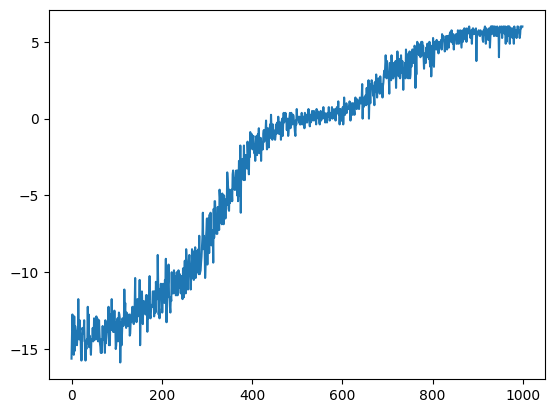

In [ ]:
plt.plot(mean_rewards)

In [ ]:
play(env, policy)